# Image Classification Using Transfer Learning

The MobileNetv3 with the pre-trained parameters in the torchvision is used for flower image classification task.

* Model architecture: MobileNetV3
* Parameter initialization: pre-trained parameters

The following steps are added:
* Data augmentation
* Imbalance class handling
* Early stop + Save model

The Oxford 102 category flower dataset is used for train and validation.

reference:
* [MobileNetV3](https://pytorch.org/vision/main/models/mobilenetv3.html) (Pytorch Documentation)
* [Flower 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)

In [ ]:
import glob
import json
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.models import mobilenet_v3_large
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Load the data

In [ ]:
# load dataset
parent_dir = '/content/drive/MyDrive/Oxford_flower_project'
data_dir = parent_dir + '/data'
train_dir = data_dir + '/train'
val_dir = data_dir + '/valid'
# test_dir = data_dir + '/test'

img_size = 128

# data augmentation for train data
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(128, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
])

# data transformation for validation data
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform= train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform= val_transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

### Check image data

In [ ]:
img, label = next(iter(train_loader))
print(img.shape)

torch.Size([128, 3, 128, 128])


In [ ]:
val_img, va_label = next(iter(val_loader))
print(val_img.shape)

torch.Size([128, 3, 128, 128])


### Sample image

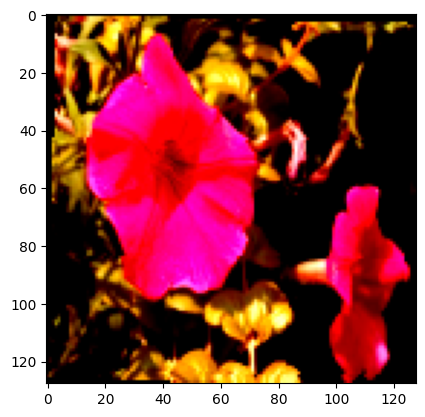

In [ ]:
img = img/2 +0.5
plt.imshow(img[0].permute(1,2,0))

## Label mapping

In [ ]:
label_path = data_dir + '/cat_to_name.json'
with open(label_path, 'r') as f:
    cat_to_name = json.load(f)

category_map = sorted(cat_to_name.items(), key=lambda x: int(x[0]))
category_names = [cat[1] for cat in category_map]

## Investigate Class Distribution

In [ ]:
class_counts = {cat_to_name[dir]: len(glob.glob(train_dir+f'/{dir}/*')) for dir in os.listdir(train_dir)}

In [ ]:
print(f"""Minimum:
  -  Class name  : {min(class_counts, key=class_counts.get)}
  -  Class counts: {min(class_counts.values())}
Maximus:
  -  Class name  : {max(class_counts, key=class_counts.get)}
  -  Class counts: {max(class_counts.values())}""")

Minimum:
  -  Class name  : pink primrose
  -  Class counts: 27
Maximus:
  -  Class name  : petunia
  -  Class counts: 206


<BarContainer object of 102 artists>

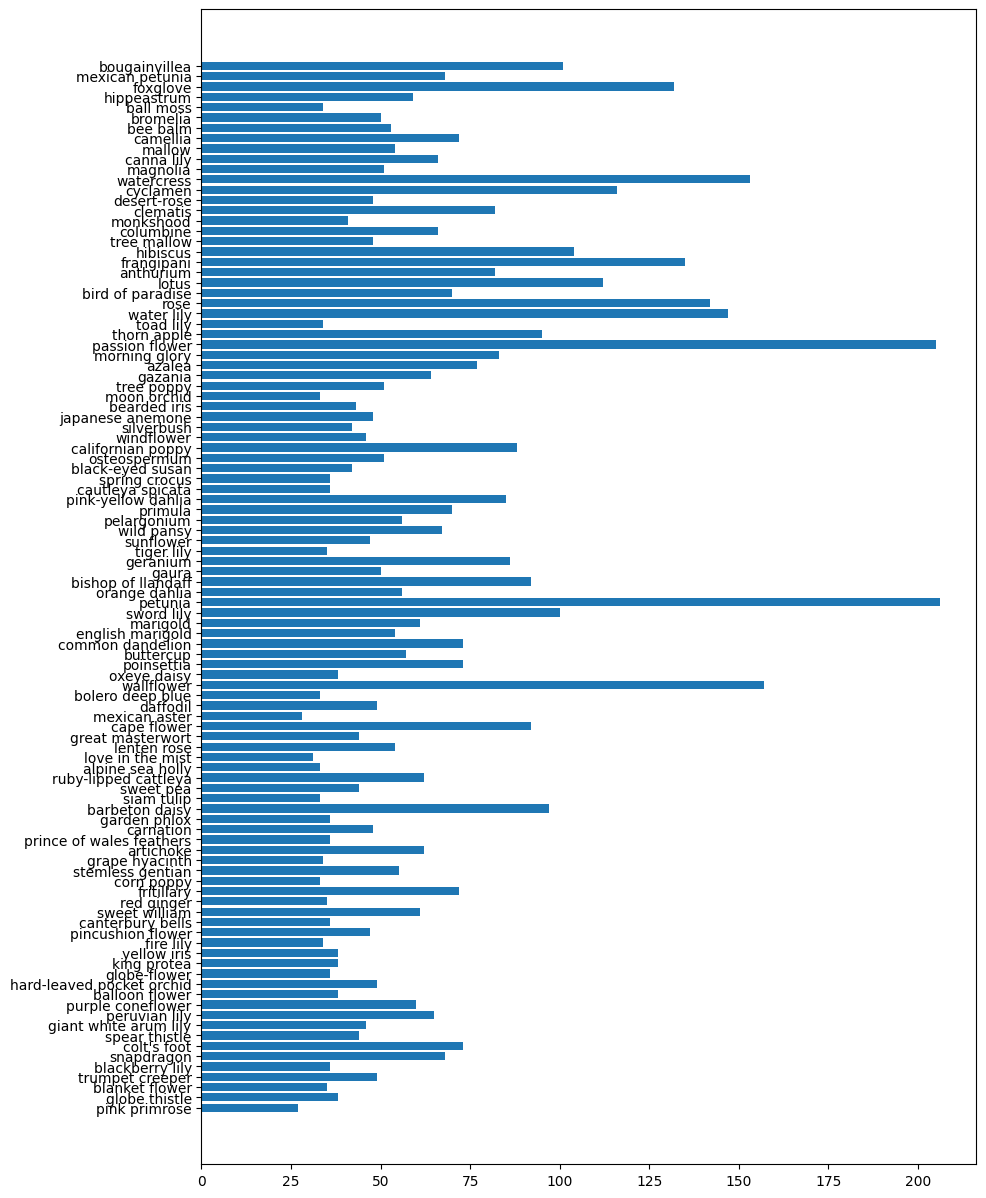

In [ ]:
plt.figure(figsize=(10,15))
plt.barh(y=class_counts.keys(), width=class_counts.values())

## Model (MobileNetV3)

In [ ]:
# load model
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)

In [ ]:
# change 1000 classes classifier to 102 classes classifier
model.classifier[-1] = nn.Linear(in_features=1280, out_features=102, bias=True)

In [ ]:
# model inspection
for name, module in model.named_modules():
  if name:
    print(name, module)

features Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.0

In [ ]:
# use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# to handle imbalanced data
train_labels = train_loader.dataset.targets
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# move model to gpu if available
model.to(device)

# define loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# adam optimizer
learning_rate = 0.001
opt = optim.Adam(model.parameters(),lr =learning_rate)

# define learning scheduler
scheduler = lr_scheduler.CosineAnnealingLR(opt, T_max=30, eta_min=0.0001)

### Learning

In [ ]:
num_epochs = 200

# Log
train_losses = []
val_losses = []
val_accuracies = []
learning_rate = {}

best_val_loss = float('inf')

# # counter for num. of no improvement
num_improv = 0
early_stop = 10

start_time = time.time()

for epoch in range(1, num_epochs):
  model.train()

  running_train_loss = 0.0
  running_val_loss = 0.0
  running_val_acc = 0.0

  for train_batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):

    X, y = data
    X, y = X.to(device), y.to(device)

    opt.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    opt.step()

    running_train_loss += loss.item()

  with torch.no_grad():
    model.eval()

    for val_batch, val_data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
      X_val, y_val = val_data
      X_val, y_val = X_val.to(device), y_val.to(device)

      y_val_pred = model(X_val)
      running_val_loss += criterion(y_val_pred, y_val).item()

      running_val_acc += torch.sum(torch.argmax(y_val_pred, dim=1) == y_val).item()/ y_val.shape[0]

    train_losses.append(running_train_loss/len(train_loader))
    val_losses.append(running_val_loss/len(val_loader))
    val_accuracies.append(running_val_acc/len(val_loader))

    print(f'Epoch : {epoch}, train losses {train_losses[-1]: .5f}, val losses {val_losses[-1]: .5f}, val accuracies {val_accuracies[-1]: .5f}')

  # Step the scheduler after every epoch
  learning_rate[epoch] = opt.param_groups[0]['lr']
  scheduler.step()

  # save model and update num. improvement counts
  if val_losses[-1] < best_val_loss:
    best_val_loss = val_losses[-1]
    # num_improv =0
    if val_accuracies[-1] > 0.90:
      torch.save(model.state_dict(), f'{parent_dir}/model_checkpoint/torch_model_state_dict_checkpoint_epoch{epoch}.pth')

  else:
    num_improv += 1

  # early stop
  if early_stop and num_improv >= early_stop:
    print('Early stopping')
    print(f'Model performance does not improve {early_stop} consecutive epochs')
    idx = val_losses.index(best_val_loss)+1 # index starts with '0'
    print(f'Best val loss: {best_val_loss: .5f} at epoch {idx}')

    break

end_time = time.time()
print(f'Time to complete {end_time-start_time:.2f} sec')

idx = val_losses.index(best_val_loss)+1 # index starts with '0'
print(f'Best val loss: {best_val_loss: .5f} at epoch {idx}')

Epoch : 1, train losses  2.09881, val losses  3.22757, val accuracies  0.36170


Epoch : 2, train losses  0.49527, val losses  1.05578, val accuracies  0.72960


Epoch : 3, train losses  0.27051, val losses  0.81494, val accuracies  0.79147


Epoch : 4, train losses  0.19602, val losses  0.66965, val accuracies  0.82558


Epoch : 5, train losses  0.15813, val losses  0.47081, val accuracies  0.85683


Epoch : 6, train losses  0.09335, val losses  0.45092, val accuracies  0.89308


Epoch : 7, train losses  0.08315, val losses  0.52652, val accuracies  0.88562


Epoch : 8, train losses  0.11925, val losses  0.47594, val accuracies  0.89705


Epoch : 9, train losses  0.07566, val losses  0.46134, val accuracies  0.90821


Epoch : 10, train losses  0.07404, val losses  0.47978, val accuracies  0.88973


Epoch : 11, train losses  0.04692, val losses  0.55446, val accuracies  0.88290


Epoch : 12, train losses  0.04762, val losses  0.42888, val accuracies  0.90598


Epoch : 13, train losses  0.05723, val losses  0.43718, val accuracies  0.88576


Epoch : 14, train losses  0.03829, val losses  0.35483, val accuracies  0.92286


Epoch : 15, train losses  0.02324, val losses  0.34489, val accuracies  0.93500


Epoch : 16, train losses  0.02113, val losses  0.33219, val accuracies  0.93674


Epoch : 17, train losses  0.01541, val losses  0.32899, val accuracies  0.93625


Epoch : 18, train losses  0.01411, val losses  0.31203, val accuracies  0.93786


Epoch : 19, train losses  0.01300, val losses  0.36590, val accuracies  0.92719


Epoch : 20, train losses  0.00566, val losses  0.30767, val accuracies  0.94518


Epoch : 21, train losses  0.00653, val losses  0.28647, val accuracies  0.94406


Epoch : 22, train losses  0.00539, val losses  0.28227, val accuracies  0.94183


Epoch : 23, train losses  0.00591, val losses  0.29611, val accuracies  0.94344


Epoch : 24, train losses  0.00295, val losses  0.28403, val accuracies  0.95076


Epoch : 25, train losses  0.00249, val losses  0.27616, val accuracies  0.95411


Epoch : 26, train losses  0.00207, val losses  0.27391, val accuracies  0.95299


Epoch : 27, train losses  0.00211, val losses  0.26942, val accuracies  0.95076


Epoch : 28, train losses  0.00167, val losses  0.27805, val accuracies  0.95188
Early stopping
Model performance does not improve 10 consecutive epochs
Best val loss:  0.26942 at epoch 27
Time to complete 1576.53 sec
Best val loss:  0.26942 at epoch 27


### The Learning Curves

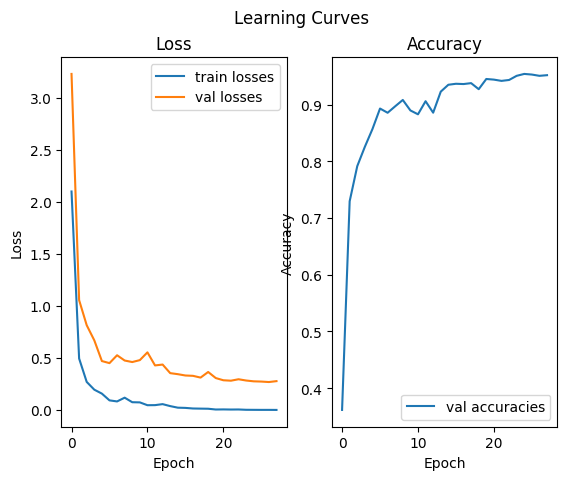

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].plot(train_losses, label = 'train losses')
ax[0].plot(val_losses, label='val losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(val_accuracies, label='val accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
fig.suptitle('Learning Curves')
fig.show()

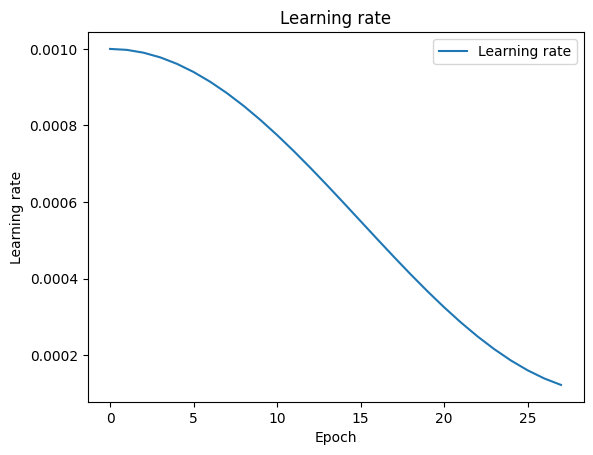

In [ ]:
plt.plot(learning_rate.values(), label='Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate')
plt.legend()

### Load the checkpoint

In [ ]:
# load the best model parameters
idx = val_losses.index(best_val_loss) +1 # idx starts with '0'
print(f'Best val loss: {best_val_loss: .5f} at epoch {idx}')
model.load_state_dict(torch.load(f'{parent_dir}/model_checkpoint/torch_model_state_dict_checkpoint_epoch{idx}.pth', map_location=torch.device('cpu')))

print('Model is loaded')

Best val loss:  0.26942 at epoch 27
Model is loaded


<ipython-input-33-cef106274e9d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{parent_dir}/model_checkpoint/torch_model_state_dict_chec

### Class Prediction

In [ ]:
# select random sample from validation dataset
sample_size = 3
choices = random.sample(range(len(val_dataset)), sample_size)
subset = Subset(val_dataset, choices)
subset_loader = DataLoader(subset, batch_size=sample_size, shuffle=False, num_workers=2)

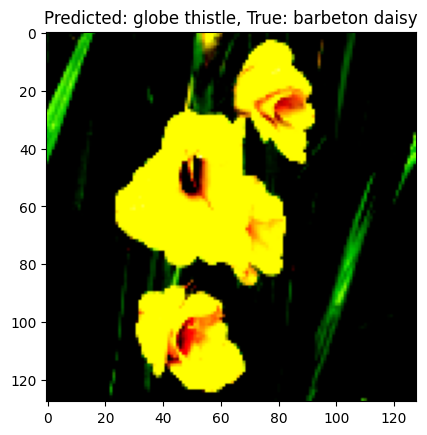

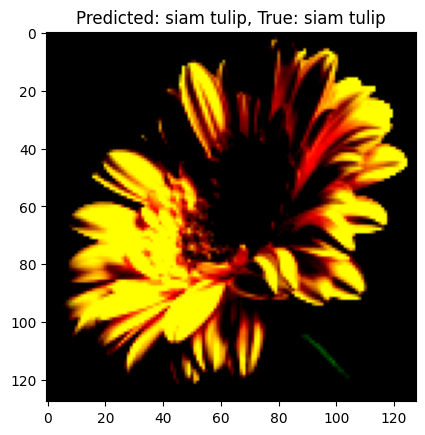

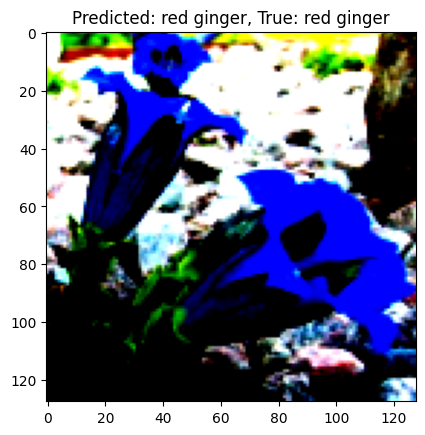

In [ ]:
model.eval()

for i, data in enumerate(subset_loader):
  with torch.no_grad():
    x, label = data
    x = x.to(device)
    preds = model(x)
    predicted_class = torch.argmax(preds, dim=1)
    for j in range(len(preds)):
      scaled_image = (x[j] * 255).clamp(0, 255).to(torch.uint8).cpu()
      plt.imshow(scaled_image.permute(1, 2, 0).numpy())
      plt.title(f'Predicted: {cat_to_name[str(predicted_class[j].item()+1)]}, True: {cat_to_name[str(label[j].item()+1)]}')
      plt.show()


## Sanity Checking

Check the values of preds and plots the top 5 categories and compare them with the true label

add codes to sort the graph ascending order.

clean the codes and comments for readability.

In [ ]:
# select random sample from validation dataset
sample_size = 2
choices = random.sample(range(len(val_dataset)), sample_size)
subset = Subset(val_dataset, choices)
subset_loader = DataLoader(subset, batch_size=sample_size, shuffle=False, num_workers=2)

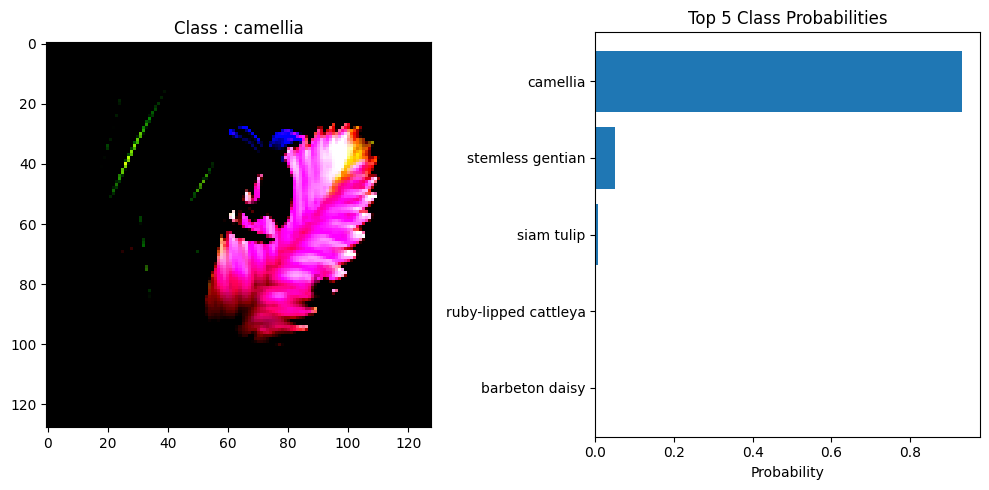

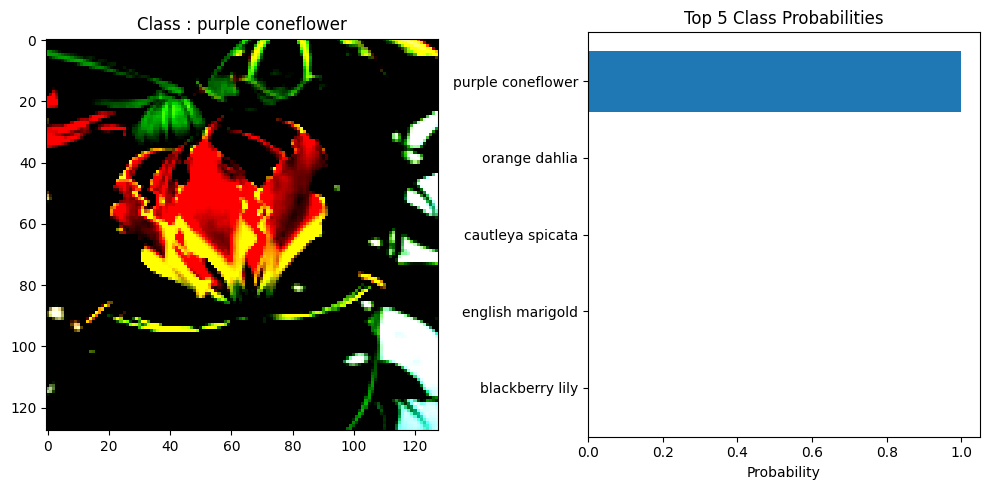

In [ ]:
model.eval()

for i, data in enumerate(subset_loader):
  with torch.no_grad():
    x, label = data
    x = x.to(device)
    preds = model(x)
    for j in range(len(preds)):
      probs = torch.nn.functional.softmax(preds[j], dim=0)

      fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(10,5), tight_layout=True)

      img_path = subset.dataset.imgs[choices[j]][0]
      scaled_image = (x[j] * 255).clamp(0, 255).to(torch.uint8).cpu()
      ax1.imshow(scaled_image.permute(1, 2, 0).numpy())
      ax1.title.set_text(f'Class : {cat_to_name[str(label[j].item()+1)]}')

      # top k values
      k = 5
      probs_top5, indices = torch.topk(probs, k)
      probs_top5_list = probs_top5.cpu().tolist()
      indices_list = indices.cpu().tolist()

      class_name = [cat_to_name[str(index+1)] for index in indices_list]
      probs_top5_list, class_name = zip(*sorted(zip(probs_top5_list, class_name)))
      ax2.barh(class_name, probs_top5_list)

      ax2.title.set_text('Top 5 Class Probabilities')
      ax2.xaxis.set_label_text('Probability')
      plt.show()
